In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pyodbc
import psycopg2
import math
import sys
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
import warnings
import pickle
from datetime import datetime
from matplotlib.ticker import PercentFormatter
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500) 
spark.sql("set spark.sql.hive.convertMetastoreOrc=true")
conf.set("spark.driver.maxResultSize", "3g")
conf.set("spark.sql.parquet.writeLegacyFormat","true")

In [2]:
df = spark.sql("""
with temp_tb as (
SELECT
 sls.co_loc_i,
 sls.co_loc_ref_i,
 sls.mdse_item_i, 
 sls.wk_end_d, 
 sls.net_sls_a as sls_a,
 sls.b_mkdn_retl_a as bmkdn

FROM prd_mrg_fnd.wk_item_loc_vend_grmrg sls

WHERE
 (sls.mdse_dept_ref_i = 211 AND sls.mdse_clas_ref_i = 3) AND
 sls.wk_end_d between '2018-12-01' and '2019-02-30'
 )
 
 
select
sls.co_loc_ref_i,
sls.wk_end_d,
i.mdse_item_i, 
i.mdse_item_desc_t,
sum(sls.sls_a) as sls, 
sum(sls.bmkdn) as bmd

from temp_tb sls
inner join prd_sho_item.mdse_item_dim i 
 on sls.mdse_item_i = i.mdse_item_i

group by
sls.co_loc_ref_i,
sls.wk_end_d,
i.mdse_item_i, 
i.mdse_item_desc_t""").toPandas() 

In [3]:
## Read store format
str_fmt = pd.read_excel('/home_dir/z003tw3/str_fmt.xlsx',index_col = 0,  header = 0)
str_fmt.columns = ['co_loc_ref_i', 'str_fmt']

## Merging two tables
df = pd.merge(df, str_fmt, how = 'left', left_on = 'co_loc_ref_i', right_on = 'co_loc_ref_i')

In [4]:
# Saving data into pickle file for easily access in the future. 
# pickle a variable to a file
file = open('slalad_sls_bmd.pickle', 'wb')
pickle.dump(df, file)
file.close()

In [5]:
with open('slalad_sls_bmd.pickle', 'rb') as file:
    df = pickle.load(file)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503833 entries, 0 to 1503832
Data columns (total 7 columns):
co_loc_ref_i        1503833 non-null int32
wk_end_d            1503833 non-null object
mdse_item_i         1503833 non-null int32
mdse_item_desc_t    1503833 non-null object
sls                 1503833 non-null object
bmd                 1503833 non-null object
str_fmt             1495579 non-null object
dtypes: int32(2), object(5)
memory usage: 80.3+ MB
None
   co_loc_ref_i    wk_end_d  mdse_item_i  \
0          1265  2019-02-16      3165101   
1          1826  2019-02-16      3165101   
2          1278  2019-02-16      3165101   
3          3236  2019-02-16      3165101   
4          1458  2019-02-16      3165101   

                            mdse_item_desc_t   sls   bmd         str_fmt  
0  Fresh Express Iceberg Garden Salad - 12oz  0.00  0.00         P FRESH  
1  Fresh Express Iceberg Garden Salad - 12oz  0.00  0.00    SUPER TARGET  
2  Fresh Express Iceberg Garden Sala

In [6]:
DF = df.copy()

In [7]:
DF = DF.drop(['mdse_item_i'], axis = 1)
DF = DF[DF['str_fmt'] == 'P FRESH']
DF['bmd'] = DF['bmd'].astype(float) 
DF['sls'] = DF['sls'].astype(float)
DF['wk_end_d'] = pd.to_datetime(df['wk_end_d'])
DF['bmd_pct'] = (DF['bmd']/DF['sls']).replace(np.inf, 0).fillna(0)

In [8]:
print(DF.info())
print(DF.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099540 entries, 0 to 1503831
Data columns (total 7 columns):
co_loc_ref_i        1099540 non-null int32
wk_end_d            1099540 non-null datetime64[ns]
mdse_item_desc_t    1099540 non-null object
sls                 1099540 non-null float64
bmd                 1099540 non-null float64
str_fmt             1099540 non-null object
bmd_pct             1099540 non-null float64
dtypes: datetime64[ns](1), float64(3), int32(1), object(2)
memory usage: 62.9+ MB
None
   co_loc_ref_i   wk_end_d                           mdse_item_desc_t  sls  \
0          1265 2019-02-16  Fresh Express Iceberg Garden Salad - 12oz 0.00   
2          1278 2019-02-16  Fresh Express Iceberg Garden Salad - 12oz 0.00   
4          1458 2019-02-16  Fresh Express Iceberg Garden Salad - 12oz 0.00   
5          2870 2019-02-16  Fresh Express Iceberg Garden Salad - 12oz 0.00   
6          1481 2019-02-16  Fresh Express Iceberg Garden Salad - 12oz 0.00   

   bmd  str_fm

In [9]:
itm_str_cnt = DF.groupby('mdse_item_desc_t')[('co_loc_ref_i')].nunique()[DF.groupby('mdse_item_desc_t')[('co_loc_ref_i')].nunique().values > 600]
str_idx = itm_str_cnt[itm_str_cnt == itm_str_cnt.min()].index

In [10]:
strdf = DF.set_index('mdse_item_desc_t')
str_lst = list(strdf.loc[str_idx]['co_loc_ref_i'].unique())

In [11]:
DF = DF.loc[DF['co_loc_ref_i'].isin(str_lst)]
DF = DF[((DF['sls']+DF['bmd']) != 0)&(DF['mdse_item_desc_t'] != 'UNKNOWN')&(DF['sls']>0)] 

In [12]:
# First let's check items individualy with there selling power & BMD values 
ttl_sls = DF['sls'].sum()
itm = DF.groupby(['mdse_item_desc_t'], as_index = False)[['bmd','sls']].sum()
itm['bmd_pct'] = (itm['bmd']/itm['sls']).fillna(0).replace(np.inf, np.nan)
itm['sls_pct'] = ((itm['sls']/ttl_sls)*100.00).fillna(0).replace(np.inf, np.nan)

print(itm.head())
print(itm.info())

                               mdse_item_desc_t       bmd        sls  bmd_pct  \
0                       50/50 Mix Garden - 10oz 39,324.45 229,065.73     0.17   
1                         Dole Butter Bliss 6oz      4.00      31.00     0.13   
2        Dole Caesar Chopped Salad Kit - 10.8oz      0.00      23.34     0.00   
3  Dole Endless Summer Premium Salad Kit - 13oz     19.95       1.20    16.62   
4          Dole Fresh Baby Spinach Blend - 10oz      0.00      17.81     0.00   

   sls_pct  
0     1.84  
1     0.00  
2     0.00  
3     0.00  
4     0.00  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 5 columns):
mdse_item_desc_t    139 non-null object
bmd                 139 non-null float64
sls                 139 non-null float64
bmd_pct             139 non-null float64
sls_pct             139 non-null float64
dtypes: float64(4), object(1)
memory usage: 6.5+ KB
None


In [13]:
# sort items by BMD% in Q4
itm.sort_values('bmd_pct', ascending = False, na_position='first')
#itm = itm.set_index('mdse_item_desc_t')
#itm = itm.reset_index()
#itm.loc['Dole Endless Summer Premium Salad Kit - 13oz'].bmd_pct = 2

,mdse_item_desc_t,bmd,sls,bmd_pct,sls_pct
3,Dole Endless Summer Premium Salad Kit - 13oz,19.95,1.20,16.62,0.00
53,Fresh Express Sweet Butter Salad Blend - 6.5oz,17.94,16.44,1.09,0.00
122,Taylor Farms Italian Chopped Salad Kit - 10.25oz,23.94,23.94,1.00,0.00
115,Sweet Earth Asian Salad Wrap 8oz,"6,806.36","7,090.99",0.96,0.06
129,Taylor Farms Organic Baby Red Butter Lettuce -...,"1,110.12","1,471.13",0.75,0.01
136,Taylor Farms Organic Sweet Baby Lettuce - 5oz ...,"1,336.85","1,985.21",0.67,0.02
104,Ready Pac Foods Sriracha Chopped Salad Kit - 13oz,"50,110.80","78,324.62",0.64,0.63
73,Ready Pac Bacon Bleu Chopped Salad Kit - 13oz,"74,729.76","118,319.04",0.63,0.95
116,Sweet Earth Taco Salad Kit - 12.5oz,"6,072.83","9,747.74",0.62,0.08
97,Ready Pac Foods Hearts of Romaine - 9oz,"80,457.70","135,085.95",0.60,1.09


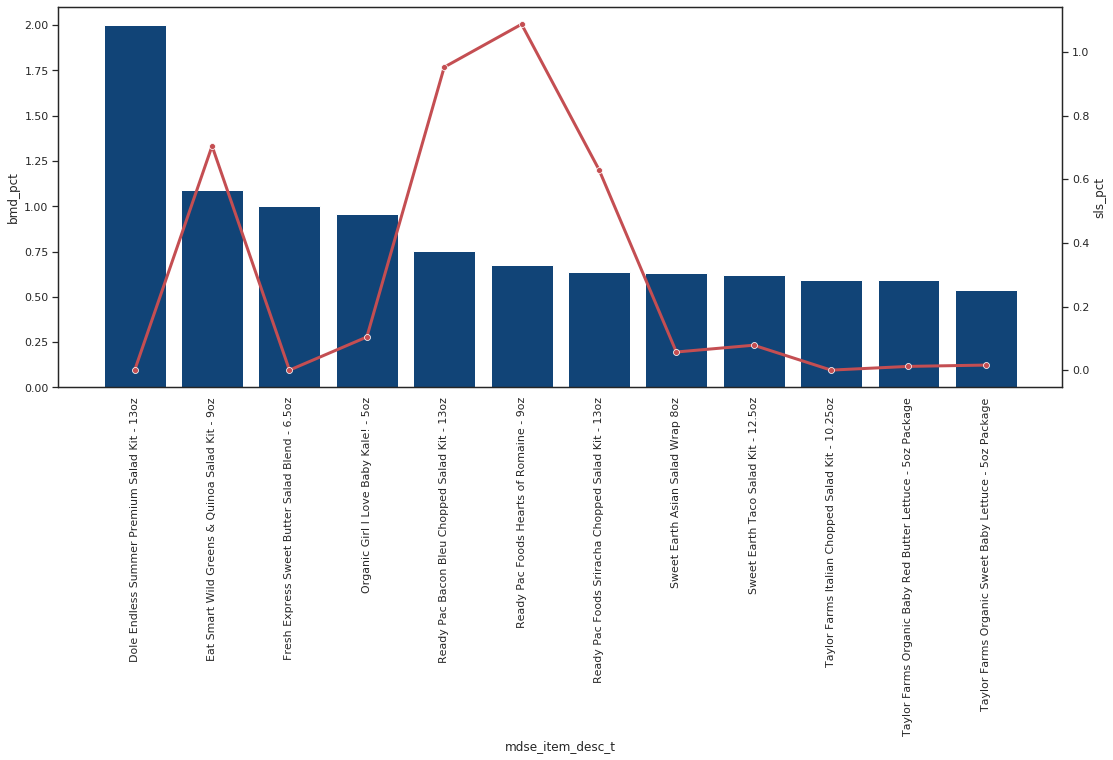

In [227]:
sns.set(style="white", rc={"lines.linewidth": 3})
fig, ax1 = plt.subplots(figsize=(18,7))
ax2 = ax1.twinx()
sns.barplot(x="mdse_item_desc_t", y="bmd_pct", data=itm[(itm['bmd_pct']>=0.5)].sort_values('bmd_pct', ascending = False, na_position='first'),
            color='#004488', 
            ax=ax1)

sns.lineplot(x="mdse_item_desc_t", y="sls_pct", data=itm[itm['bmd_pct']>=0.5].sort_values('bmd_pct', ascending = False, na_position='first'),
             color='r',
             marker="o",
             ax=ax2)

for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
plt.show()
sns.set()

Within 600 pilot stores, we are looking for a new assortment strategy that helps the grocery store to reduce waste (BMD) and the cost of carrying in the category of bagged salad. As the plot shows, some top-ranked wasted items have really low selling power. Items like these now only unprofitable, but also taking spaces for better performance items. So after discussing with the buyer and merchant planner, we decide to remove some of these items in on shelve to see if it help us increase the profit. However, limit the variance of the assortment could lead to the sales decrease. Also, there are items which performance suck, but there are the **key items** that the grocery store has to carry due to the contract with the vendor, or the items like spinach are not cuttable because it's essential for our clients. The discussion with salad buyers and merchant planner is a must to decide what items to cut.

**Hypothesis**. New assortment is going to decrease our markdown and carrying the cost; the salse lost is likely transfer to similar items remain, so end up increase our profit within the bagged salad. 

**Treatment**. Stores will be tested with a new assortment that the buyer designed: A narrower and deeper selection in variety on the shelve. Ideal scenario is to cut 20% of the current assortment, which takes up to half or more category BMD in total.

**Rollout Plan**. At the begging of the summer, we will implement treatment toward 300 of 600 stores with the new assortments for 3 weeks. Then collect the data of sales, week, and BMD values for these periods. Within these three weeks, we are going to measure the **BMD rate** by a store in category bagged salad and compared to the period right before the new assortment rollout. If the BMD% increase after 2 weeks, we will stop the experiment, get back to the old assortment. 

**Key Metric**. We will use a B-markdown percent, which takes care of the sales lost and velocity, represent the rate of the lost. 

**Measurement** First, calculate the BMD% delta between test groups before rollout and after rollout. Then compare with the difference of control group's before and after. We took two delta values against each other, calculate the T-test value to see if they are significantly different by using t-static to calculate P-value. If the P-value is lower then 0.05, we reject the H0, which is: there is no significant difference between the test and control group. 

**Heads up**
We will need to use inventory metrics to check if the store implemented the new assortment correctly; manually placing the items on shelves often not align with the merchant's shelve plan. To select the stores of treatment, we could use propensity score matching to choose both groups to have similar attributes. For produce, seasonality id strong, so we have to constraint our testing group short. Another aspect worth considerared: if we decided to roll out the new assortment, we need to calculate the sale and BMD dollar separately to see if the drop in BMD makeup the sales lost, but this will only matter after we reject the null hypothesis.